Basic statistics of corpus

Total number of inmates: 591

Timeframe associated with last statements:
Earliest statement: 1982-12-07 00:00:00
Latest statement: 2024-10-01 00:00:00

Race Demographics:
White: 263
Black: 211
Hispanic: 113
Other: 4

Age Statistics:
Average age: 40.2
Youngest: 24
Oldest: 78

Top Counties:
County
Harris     135
Dallas      65
Bexar       46
Tarrant     45
Nueces      17
Name: count, dtype: int64


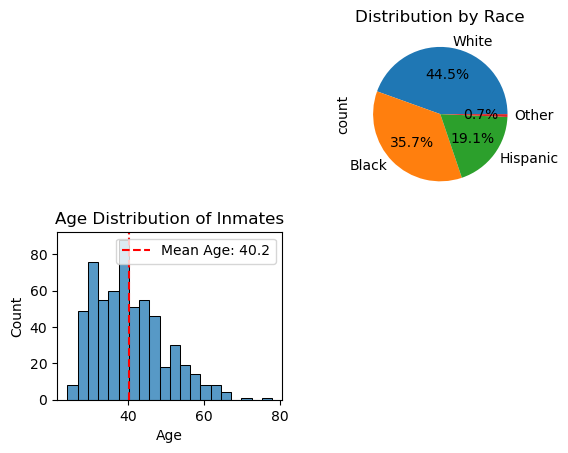

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
deathrow_info = pd.read_csv('data/deathrow_info/executed_inmates.csv')

# number of inmates
total_inmates = len(deathrow_info)
print(f"Total number of inmates: {total_inmates}")

# the earliest and latest last statement
deathrow_info['Date'] = pd.to_datetime(deathrow_info['Date'])
earliest = deathrow_info['Date'].min()
latest = deathrow_info['Date'].max()

print(f"\nTimeframe associated with last statements:")
print(f"Earliest statement: {earliest}")
print(f"Latest statement: {latest}")

# race demographics
race_counts = deathrow_info['Race'].value_counts()

print("\nRace Demographics:")
for race, count in race_counts.items():
    print(f"{race}: {count}")

plt.subplot(2, 2, 2)
race_counts = deathrow_info['Race'].value_counts()
race_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution by Race')

# age statistics
age_mean = deathrow_info['Age'].mean()
age_min = deathrow_info['Age'].min()
age_max = deathrow_info['Age'].max()

print("\nAge Statistics:")
print(f"Average age: {age_mean:.1f}")
print(f"Youngest: {age_min}")
print(f"Oldest: {age_max}")

plt.subplot(2, 2, 3)
sns.histplot(data=deathrow_info, x='Age', bins=20)
plt.title('Age Distribution of Inmates')
plt.xlabel('Age')
plt.ylabel('Count')
plt.axvline(age_mean, color='r', linestyle='--', label=f'Mean Age: {age_mean:.1f}')
plt.legend()

# county statistics
county_counts = deathrow_info['County'].value_counts()
print("\nTop Counties:")
print(county_counts.head())

Cleaned up dataset:

In [19]:
import pandas as pd

In [20]:
# load the dataset
deathrow_info = pd.read_csv('data/deathrow_info/executed_inmates.csv')

# filter out any variation of "no statement"
deathrow_info_with_statements = deathrow_info[
    ~deathrow_info['Last Statement'].str.lower().str.contains('no statement', na=False)
]

# update the total number of inmates
total_inmates = len(deathrow_info_with_statements)
print(f"Total number of inmates with statements: {total_inmates}")

Total number of inmates with statements: 586


Vickie's modeling task: Find the different kinds of sentiments using BERT embeddings and GPT-2

In [6]:
from transformers import pipeline
from transformers import pipeline
from tqdm import tqdm

In [23]:
# process last statements with pretrained BERT emotion classification
def analyze_emotions_bert(df):
    classifier = pipeline(
        "text-classification",
        model='bhadresh-savani/bert-base-uncased-emotion', 
        return_all_scores=True,
        truncation=True,  
        max_length=512)
    
    all_emotions = []

    for statement in tqdm(df['Last Statement'], desc="Analyze statements"):
        result = classifier(str(statement))[0]
        emotion_scores = {pred['label']: pred['score'] for pred in result}

        all_emotions.append(emotion_scores)

    
    # create emotion dataframe 
    emotions_df = pd.DataFrame(all_emotions)

    emotions_df['dominant_emotion'] = emotions_df[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].idxmax(axis=1)

    result_df = pd.concat([df, emotions_df], axis=1)

    return result_df

def process_deathrow_statements(df):
    results = analyze_emotions_bert(df)

    return results


# process the statements
df = deathrow_info_with_statements
results = process_deathrow_statements(df)

# basic analysis
print("\nEmotion Distribution:")
print(results['dominant_emotion'].value_counts())

# average emotion scores
print("\nAverage Emotion Scores:")
print(results[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']].mean())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/vickieknight/anaconda3/envs/info498b/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analyze statements: 100%|██████████| 586/586 [01:13<00:00,  7.93it/s]



Emotion Distribution:
dominant_emotion
joy         298
anger       147
sadness     108
love         29
fear          3
surprise      1
Name: count, dtype: int64

Average Emotion Scores:
sadness     0.193970
joy         0.465770
love        0.089971
anger       0.231989
fear        0.015998
surprise    0.002301
dtype: float64


In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def analyze_emotions_gpt(df):
    tokenizer = AutoTokenizer.from_pretrained("heegyu/gpt2-emotion")
    model = AutoModelForCausalLM.from_pretrained("heegyu/gpt2-emotion")
    classifier = pipeline(
        "text-generation",
        tokenizer=tokenizer,
        model=model,
        device=0  # Use GPU
    )
    
    all_emotions = []
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    for statement in tqdm(df['Last Statement'], desc="Analyzing emotions"):
        try:
            input_text = tokenizer.decode(tokenizer.encode(statement, max_length=50, truncation=True))
            result = classifier(input_text, max_length=100, num_return_sequences=1)
            
            emotion_dict = {emotion: 0 for emotion in emotion_labels}
            generated_text = result[0]['generated_text'].lower()
            for emotion in emotion_labels:
                if emotion in generated_text:
                    emotion_dict[emotion] = generated_text.count(emotion) / len(generated_text)
            
            total_score = sum(emotion_dict.values())
            if total_score > 0:
                emotion_dict = {k: v / total_score for k, v in emotion_dict.items()}
            else:
                emotion_dict['other_emotions'] = 1.0
        except Exception as e:
            print(f"Error processing statement: {e}")
            emotion_dict = {'error': 1.0, 'other_emotions': 0.0}
        
        all_emotions.append(emotion_dict)
    
    emotions_df = pd.DataFrame(all_emotions)
    emotions_df['dominant_emotion'] = emotions_df.idxmax(axis=1)
    result_df = pd.concat([df, emotions_df], axis=1)
    
    return result_df

def process_deathrow_statements(df):
    results = analyze_emotions_gpt(df)
    
    # Print analysis
    print("\nEmotion Distribution:")
    print(results['dominant_emotion'].value_counts())
    
    print("\nAverage Emotion Scores:")
    # Exclude the dominant_emotion column when calculating means
    emotion_columns = [col for col in results.columns if col not in ['dominant_emotion'] + list(df.columns)]
    print(results[emotion_columns].mean())
    
    return results

# Usage:
df = deathrow_info_with_statements
results = process_deathrow_statements(df)

Analyzing emotions:   6%|▌         | 36/586 [01:03<06:45,  1.36it/s] 

Error processing statement: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]


Analyzing emotions:   8%|▊         | 47/586 [01:10<08:59,  1.00s/it]

Error processing statement: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]


Analyzing emotions: 100%|██████████| 586/586 [09:32<00:00,  1.02it/s]


Emotion Distribution:
dominant_emotion
other_emotions    338
love              223
joy                12
fear                6
sadness             3
anger               2
error               2
Name: count, dtype: int64

Average Emotion Scores:
sadness           0.003139
joy               0.018536
love              0.381721
anger             0.005137
fear              0.012700
surprise          0.000000
other_emotions    0.994118
error             1.000000
dtype: float64


Visualizations to compare BERT & GPT-2

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/vickieknight/anaconda3/envs/info498b/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Analyzing emotions:   6%|▌         | 36/586 [00:40<04:30,  2.03it/s]

Error processing statement: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]


Analyzing emotions:   8%|▊         | 46/586 [00:48<07:34,  1.19it/s]

Error processing statement: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]


Analyzing emotions: 100%|██████████| 586/586 [09:45<00:00,  1.00it/s]


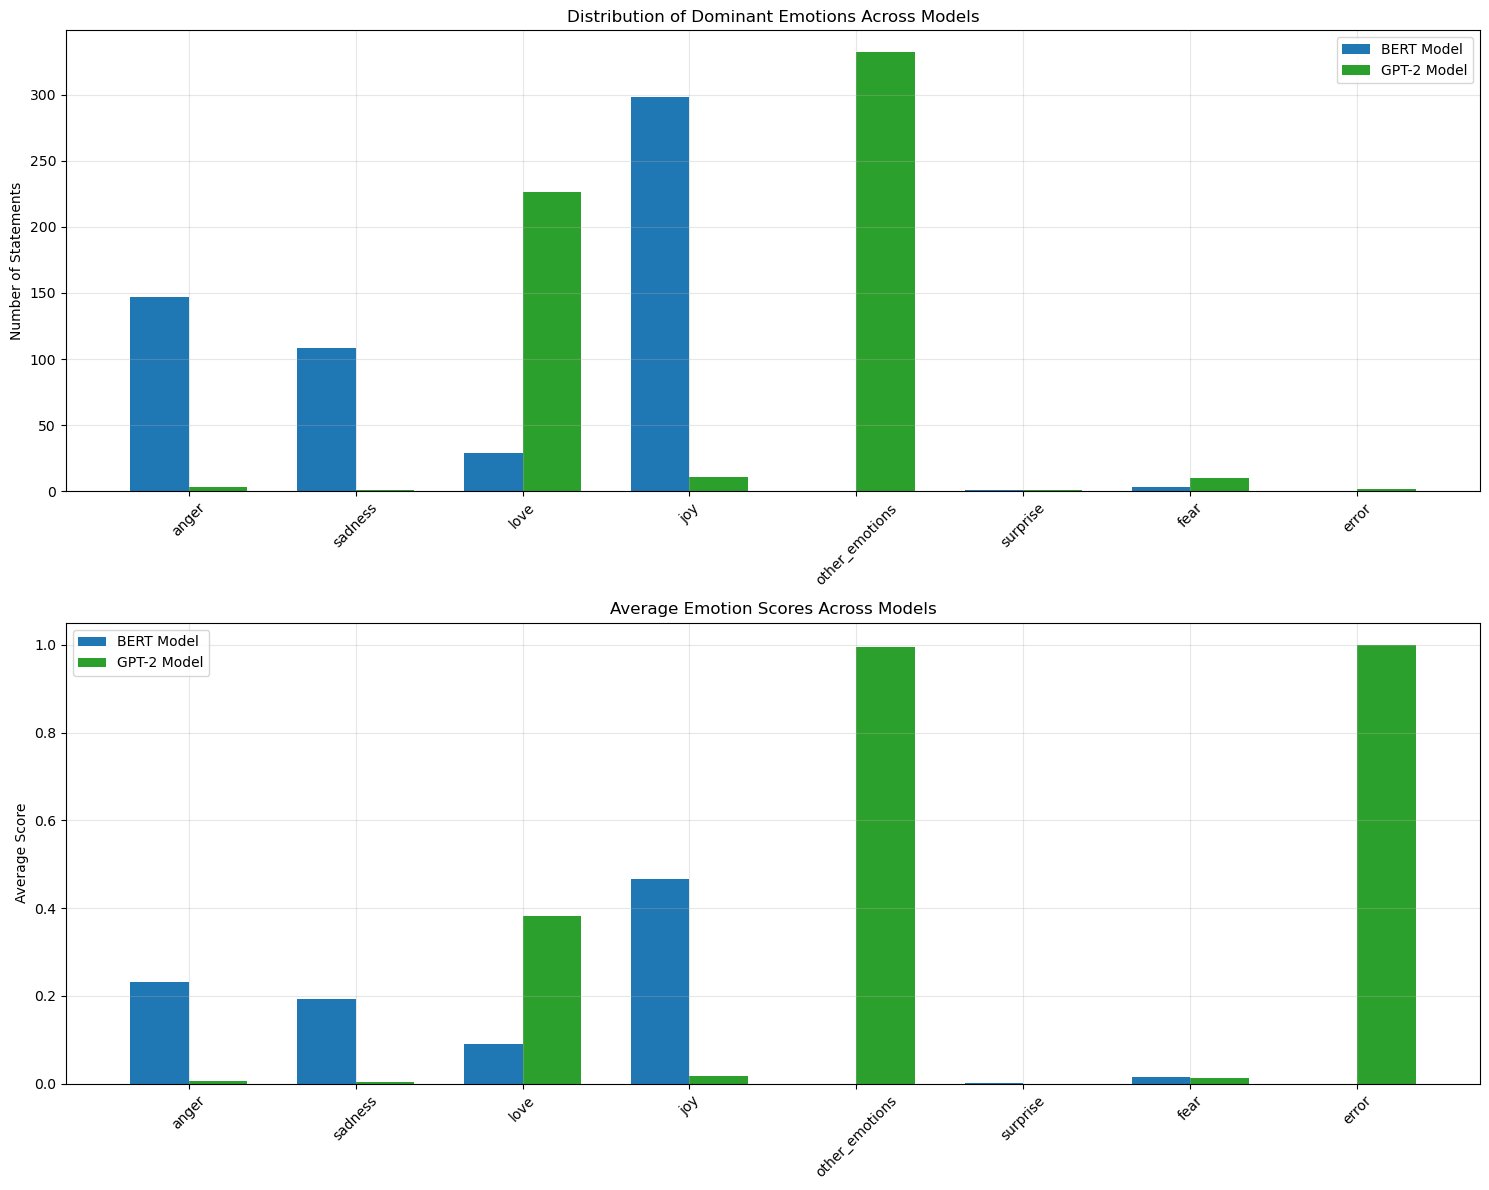

In [44]:
import matplotlib.pyplot as plt

bert_results = analyze_emotions_bert(df) 
gpt_results = analyze_emotions_gpt(df)

# Set figure size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Distribution Comparison
bert_dist = bert_results['dominant_emotion'].value_counts()
gpt2_dist = gpt_results['dominant_emotion'].value_counts()

# Get all unique emotions from both models
all_emotions = list(set(bert_dist.index) | set(gpt2_dist.index))
bert_counts = [bert_dist.get(emotion, 0) for emotion in all_emotions]
gpt2_counts = [gpt2_dist.get(emotion, 0) for emotion in all_emotions]

# Plot distribution
x = range(len(all_emotions))
width = 0.35

ax1.bar([i - width/2 for i in x], bert_counts, width, label='BERT Model', color='#1f77b4')
ax1.bar([i + width/2 for i in x], gpt2_counts, width, label='GPT-2 Model', color='#2ca02c')
ax1.set_xticks(x)
ax1.set_xticklabels(all_emotions, rotation=45)
ax1.set_ylabel('Number of Statements')
ax1.set_title('Distribution of Dominant Emotions Across Models')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Average Scores Comparison
bert_emotion_cols = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
bert_avgs = bert_results[bert_emotion_cols].mean()

# Get GPT-2 average scores (excluding non-emotion columns)
gpt2_emotion_cols = [col for col in results.columns if col not in ['dominant_emotion'] + list(df.columns)]
gpt2_avgs = results[gpt2_emotion_cols].mean()

# Combine and plot averages
all_emotions_avg = list(set(bert_emotion_cols) | set(gpt2_emotion_cols))
bert_avgs_plot = [bert_avgs.get(emotion, 0) for emotion in all_emotions_avg]
gpt2_avgs_plot = [gpt2_avgs.get(emotion, 0) for emotion in all_emotions_avg]

ax2.bar([i - width/2 for i in x], bert_avgs_plot, width, label='BERT Model', color='#1f77b4')
ax2.bar([i + width/2 for i in x], gpt2_avgs_plot, width, label='GPT-2 Model', color='#2ca02c')
ax2.set_xticks(x)
ax2.set_xticklabels(all_emotions_avg, rotation=45)
ax2.set_ylabel('Average Score')
ax2.set_title('Average Emotion Scores Across Models')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/mt/c_88523n41z85rl9zwh25cr40000gn/T/ipykernel_51340/106399674.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['statement_length'] = df['Last Statement'].str.len()


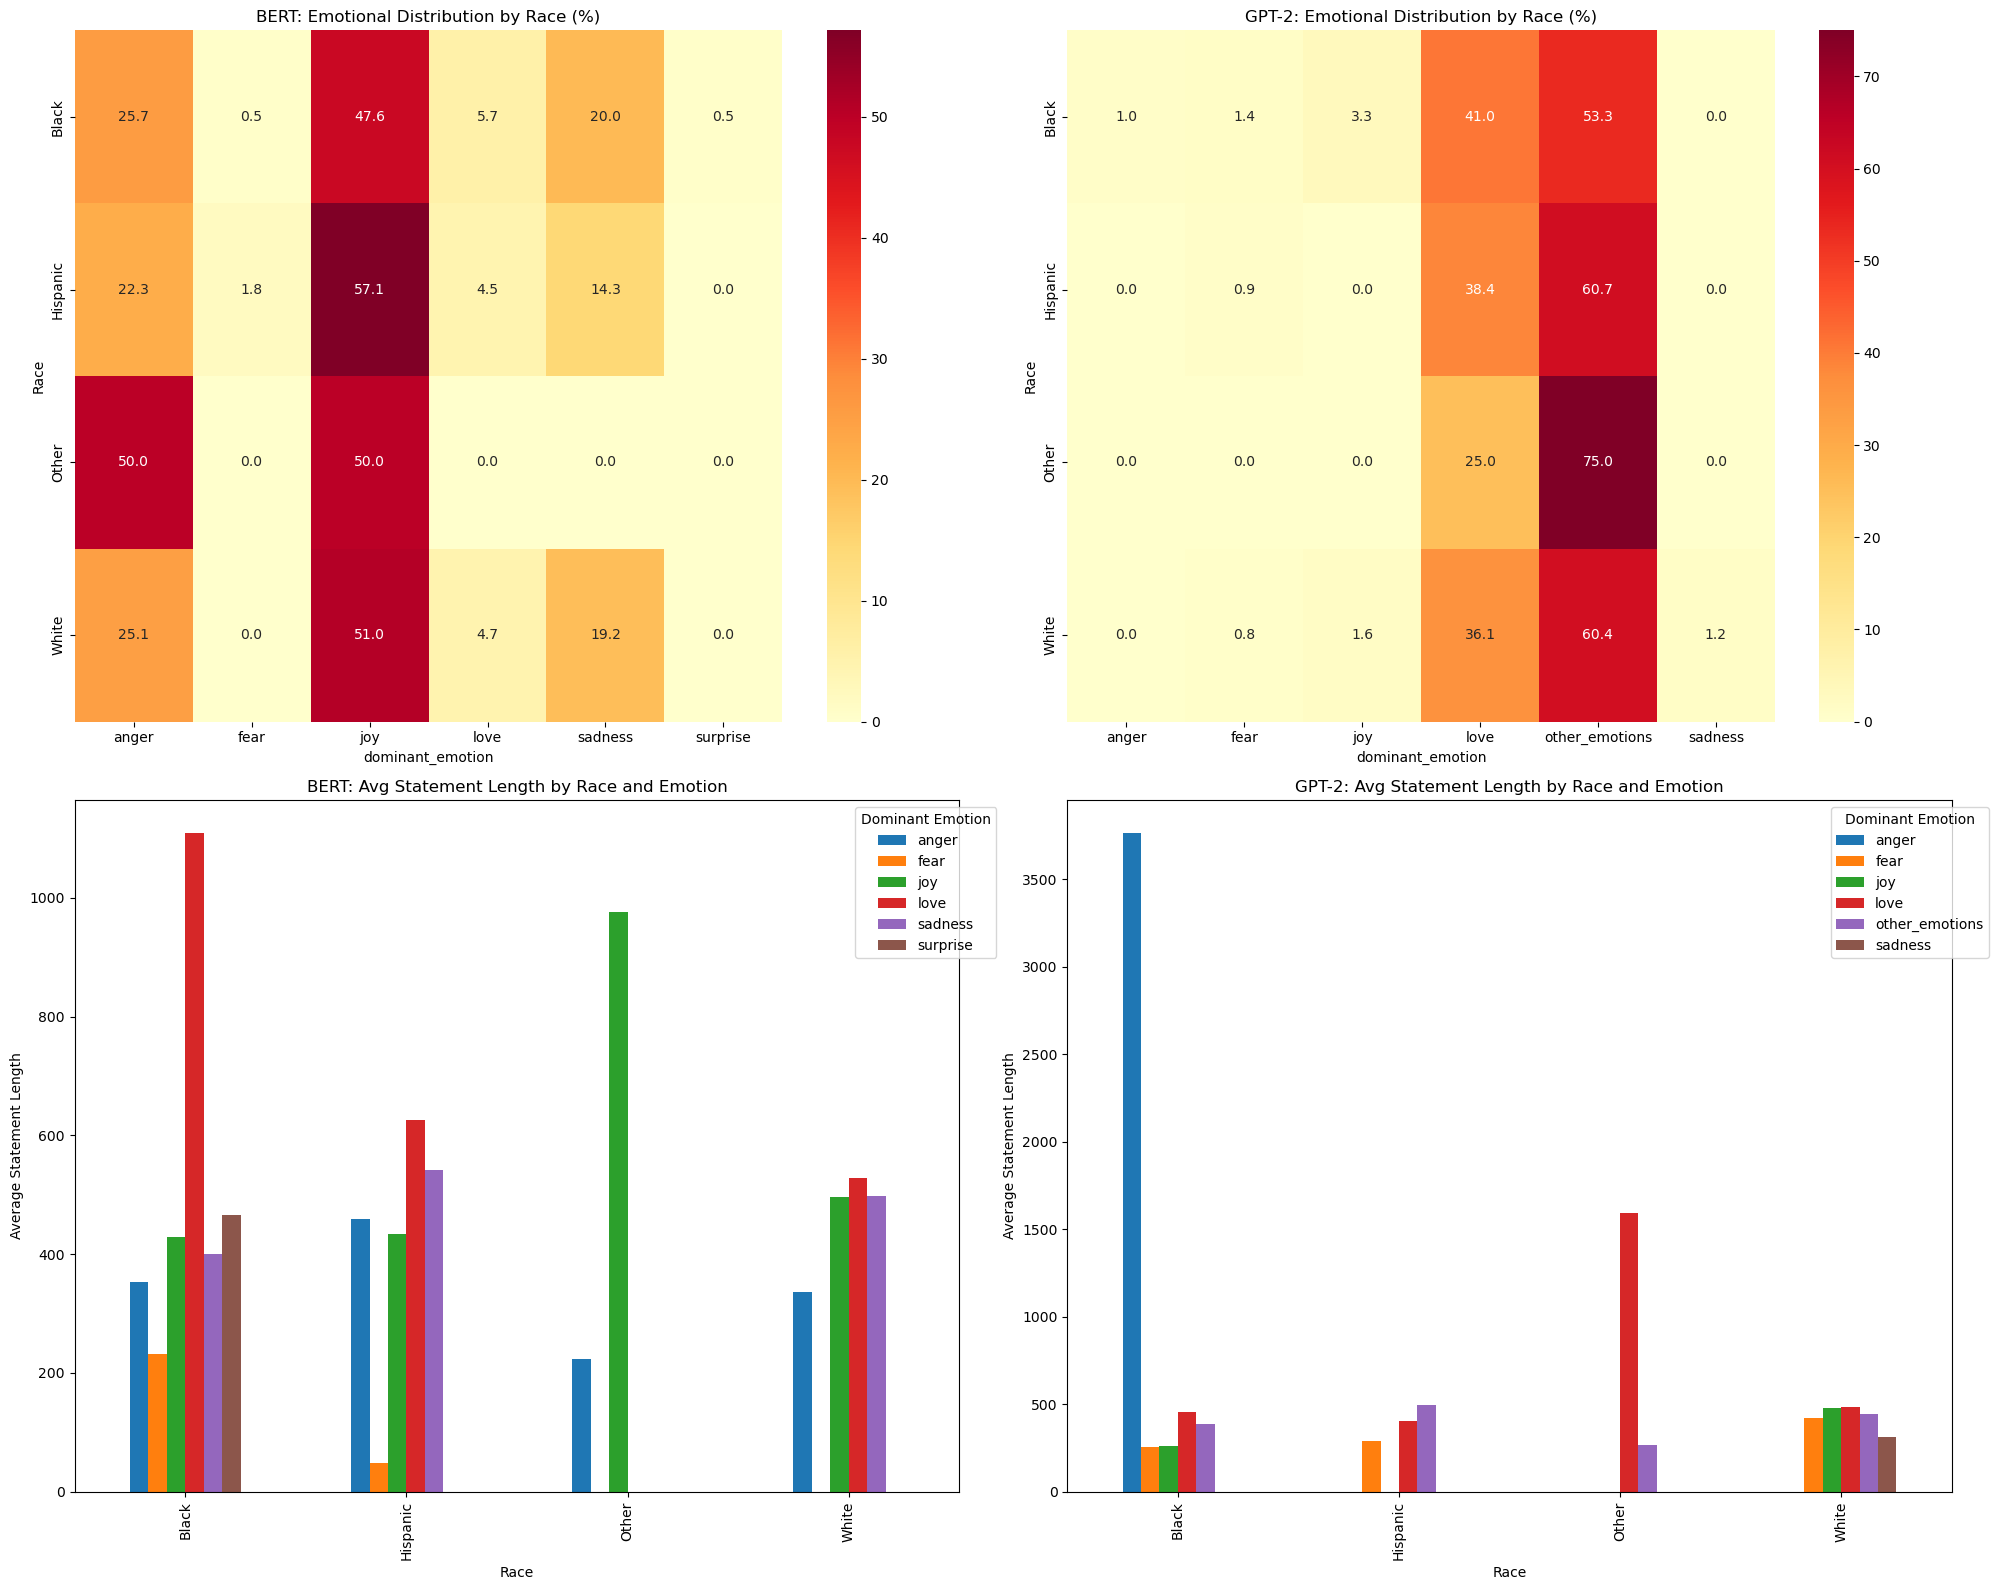

/var/folders/mt/c_88523n41z85rl9zwh25cr40000gn/T/ipykernel_51340/106399674.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = pd.to_datetime(df['Date']).dt.year


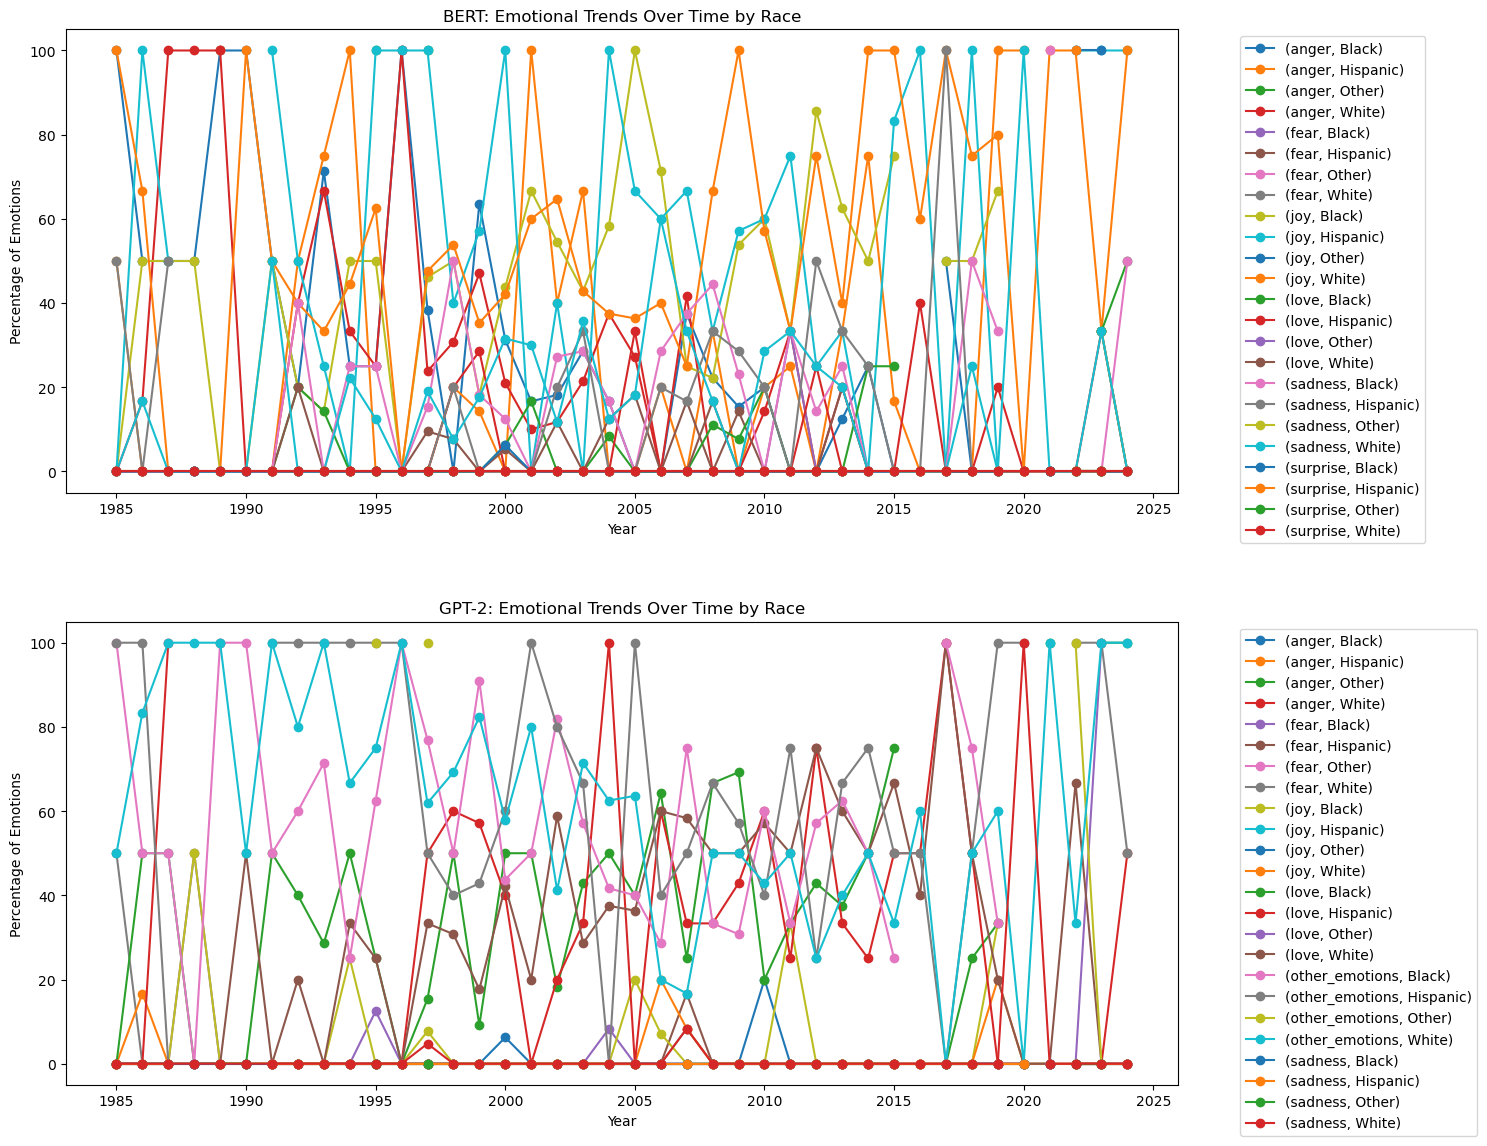


Statistical Analysis:

Average Statement Length by Race:
            mean  count     std
Race                           
Black     443.45    211  650.32
Hispanic  457.02    112  489.30
Other     600.25      4  669.96
White     456.95    257  556.24

Chi-square test for Race vs Emotions:

BERT Model:
Chi-square statistic: 11.95
p-value: 0.6831

GPT-2 Model:
Chi-square statistic: 14.82
p-value: 0.4643


In [43]:
# Analyze emotions by race/ethnicity for both models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Emotion Distribution by Race for BERT
race_emotion_bert = pd.crosstab(df['Race'], bert_results['dominant_emotion'], normalize='index') * 100
sns.heatmap(race_emotion_bert, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1)
ax1.set_title('BERT: Emotional Distribution by Race (%)')
ax1.set_ylabel('Race')

# 2. Emotion Distribution by Race for GPT-2
race_emotion_gpt2 = pd.crosstab(df['Race'], results['dominant_emotion'], normalize='index') * 100
sns.heatmap(race_emotion_gpt2, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
ax2.set_title('GPT-2: Emotional Distribution by Race (%)')
ax2.set_ylabel('Race')

# 3. Average Statement Length by Race and Dominant Emotion
df['statement_length'] = df['Last Statement'].str.len()

# For BERT
bert_length_analysis = df.groupby(['Race', bert_results['dominant_emotion']])['statement_length'].mean().unstack()
bert_length_analysis.plot(kind='bar', ax=ax3)
ax3.set_title('BERT: Avg Statement Length by Race and Emotion')
ax3.set_xlabel('Race')
ax3.set_ylabel('Average Statement Length')
ax3.legend(title='Dominant Emotion', bbox_to_anchor=(1.05, 1))

# For GPT-2
gpt2_length_analysis = df.groupby(['Race', results['dominant_emotion']])['statement_length'].mean().unstack()
gpt2_length_analysis.plot(kind='bar', ax=ax4)
ax4.set_title('GPT-2: Avg Statement Length by Race and Emotion')
ax4.set_xlabel('Race')
ax4.set_ylabel('Average Statement Length')
ax4.legend(title='Dominant Emotion', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Additional Analysis: Time Series of Emotions by Year
fig, (ax5, ax6) = plt.subplots(2, 1, figsize=(15, 12))

# Convert execution date to year
df['Year'] = pd.to_datetime(df['Date']).dt.year

# BERT Emotional trends over time by race
bert_yearly = pd.crosstab([df['Year'], df['Race']], 
                         bert_results['dominant_emotion'],
                         normalize='index') * 100

bert_yearly.unstack().plot(marker='o', ax=ax5)
ax5.set_title('BERT: Emotional Trends Over Time by Race')
ax5.set_xlabel('Year')
ax5.set_ylabel('Percentage of Emotions')
ax5.legend(bbox_to_anchor=(1.05, 1))

# GPT-2 Emotional trends over time by race
gpt2_yearly = pd.crosstab([df['Year'], df['Race']], 
                         results['dominant_emotion'],
                         normalize='index') * 100

gpt2_yearly.unstack().plot(marker='o', ax=ax6)
ax6.set_title('GPT-2: Emotional Trends Over Time by Race')
ax6.set_xlabel('Year')
ax6.set_ylabel('Percentage of Emotions')
ax6.legend(bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Print statistical analysis
print("\nStatistical Analysis:")
print("\nAverage Statement Length by Race:")
print(df.groupby('Race')['statement_length'].agg(['mean', 'count', 'std']).round(2))

# Chi-square test for independence between race and emotions
from scipy.stats import chi2_contingency

print("\nChi-square test for Race vs Emotions:")
print("\nBERT Model:")
chi2, p_val, dof, expected = chi2_contingency(pd.crosstab(df['Race'], bert_results['dominant_emotion']))
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.4f}")

print("\nGPT-2 Model:")
chi2, p_val, dof, expected = chi2_contingency(pd.crosstab(df['Race'], results['dominant_emotion']))
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.4f}")